# How Has the Men's 100 Metres Sprint Evolved Over the Years? Analysing the Men's 100 Metres Sprint Data

#### Men's 100 Metres Sprint, 1958 - Present (10.30 Seconds and Below)
#### Tas Mitaros
#### 27<sup><font size="1">th</font></sup> November, 2024

## _*Background*_
#### The data is taken from [worldathletics.org](https://worldathletics.org/records/all-time-toplists/sprints/100-metres/outdoor/men/senior?regionType=world&timing=electronic&windReading=regular&page=1&bestResultsOnly=false&firstDay=1900-01-01&lastDay=2024-11-27) of all male times 10.30 seconds and below in the 100m, from 1958 until present.

### <b>Objectives</b>
##### I explore the following questions in this analysis:
1. What is the distribution of male 100m times?
2. What is the most common age for a male athlete to run his personal best?
3. What are the fastest times for each nation?
4. How has the male 100m world record progressed over time?
5. How has the world lead (fastest time in the year) progressed over time?
6. Which athletes have achieved the most sub 10.00, 9.90 and 9.80 second performances?
7. Who are the youngest and oldest athletes to achieve sub 10 second performances?
8. What is the fastest time that didn't place first?
9. How has Australian sprinting progressed over time?

### <b>About the Data</b>
##### The raw data consists of the following fields:
* `Rank` : The ranking of the time amongst all others to date
* `Mark` : The time achieved in seconds, rounded to 2 decimal places
* `WIND` : The windspeed present during the duration of the race
* `Competitor` : The full name of the athlete
* `DOB` : The athlete's date of birth
* `Nat` : The athlete's nationality
* `Pos` : The final position achieved in the race by the athlete
* `Venue` : The venue that the race took place
* `Date` : The date that the race took place
* `Results Score` : The athlete's score in the race as determined by <i>World Athletics</i>
##### The dataset has been enriched with the following fields via feature engineering:
* `Competitor Nat` : The name and nationality of the athlete
* `Age` : The athlete's age on the day the race took place
* `Current Age` : The athlete's current age as of this analysis
* `Pos Adjusted` : The final position achieved in the race by the athlete, represented as a single integer
* `Is Personal Best` : Binary 'Yes' or 'No' if the time is the athlete's best
* `Personal Best` : The best time achieved by the athlete
* `Is National Record` : Binary 'Yes' or 'No' if the time is the nation's best
* `Year` : The year that the race took place
* `Nation` : The full name of the nation represented by the athlete
* `Longitude` : The longitude of the nation
* `Latitude` : The latitude of the nation
  
<i>It should be noted that each row in the dataset represents one race of an athlete. Many athletes' names are present in the dataset multiple times due to them achieving multiple performances of 10.30 seconds and below.</i>

### Import Libraries and Datasets

In [1]:
import operator
import numpy as np
import polars as pl
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pl.read_csv("100m_sprint_records.csv")
df_countries = pl.read_csv("countries.csv")

### Data Cleaning
The dataset contains 314 records with null values in the `DOB` field that have been filtered out to ensure data cleanliness in the subsequent calculations and analyses. The resultant dataset contains a total of 27,046 rows and 10 columns.
<br> The `DOB` and `Date` fields are then converted from string values to date values for ease of subsequent feature engineering and analysis.

In [2]:
# Remove records with invalid date values
df = df.filter(
    pl.col("DOB")
    .str.strptime(pl.Date, format="%d %b %Y", strict=False)
    .is_not_null()
)
# Convert columns to dates
df = df.with_columns(
    pl.col("DOB").str.strptime(pl.Date, format="%d %b %Y"),
    pl.col("Date").str.strptime(pl.Date, format="%d %b %Y")
)

### Feature Engineering
The dataset has been enriched with additional fields calculated using the existing 100m dataset and by joining the countries dataset.

In [3]:
# Add additional fields
df = df.with_columns(
    pl.concat_str(pl.col("Competitor"), pl.lit(" ("), pl.col("Nat"), pl.lit(")")).alias("Competitor Nat"),
    ((pl.col("Date") - pl.col("DOB")).dt.total_days() / 365.25).cast(int).alias("Age"),
    ((pl.lit(date.today()) - pl.col("DOB")).dt.total_days() / 365.25).cast(int).alias("Current Age"),
    pl.col("Pos").str.extract(r"^(\d+)", 1).alias("Pos Adjusted"),
    (pl.col("Mark").rank("ordinal").over("Competitor") == 1).alias("Is Personal Best"),
    pl.col("Mark").min().over("Competitor").alias("Personal Best"),
    (pl.col("Mark").rank("ordinal").over("Nat") == 1).alias("Is National Record"),
    pl.col("Date").dt.year().alias("Year")
)

# Join countries data to athletes' nationality
df = df.join(df_countries, left_on="Nat", right_on="Country Code", how="left").rename({"Country": "Nation"})

df.head()

Rank,Mark,WIND,Competitor,DOB,Nat,Pos,Venue,Date,Results Score,Competitor Nat,Age,Current Age,Pos Adjusted,Is Personal Best,Personal Best,Is National Record,Year,Nation,Longitude,Latitude
i64,f64,f64,str,date,str,str,str,date,i64,str,i64,i64,str,bool,f64,bool,i32,str,f64,f64
1,9.58,0.9,"""Usain BOLT""",1986-08-21,"""JAM""","""1""","""Olympiastadion, Berlin (GER)""",2009-08-16,1356,"""Usain BOLT (JAM)""",22,38,"""1""",true,9.58,true,2009,"""Jamaica""",-77.2975,18.1096
2,9.63,1.5,"""Usain BOLT""",1986-08-21,"""JAM""","""1""","""Olympic Stadium, London (GBR)""",2012-08-05,1337,"""Usain BOLT (JAM)""",25,38,"""1""",false,9.58,false,2012,"""Jamaica""",-77.2975,18.1096
3,9.69,0.0,"""Usain BOLT""",1986-08-21,"""JAM""","""1""","""National Stadium, Beijing (CHN…",2008-08-16,1316,"""Usain BOLT (JAM)""",21,38,"""1""",false,9.58,false,2008,"""Jamaica""",-77.2975,18.1096
3,9.69,2.0,"""Tyson GAY""",1982-08-09,"""USA""","""1""","""Shanghai (CHN)""",2009-09-20,1316,"""Tyson GAY (USA)""",27,42,"""1""",true,9.69,true,2009,"""United States""",-95.7129,37.0902
3,9.69,-0.1,"""Yohan BLAKE""",1989-12-26,"""JAM""","""1""","""Stade Olympique de la Pontaise…",2012-08-23,1316,"""Yohan BLAKE (JAM)""",22,34,"""1""",true,9.69,false,2012,"""Jamaica""",-77.2975,18.1096


### 1. What is the distribution of male 100m times?
<font size="3">
The histograms and boxplot below show the distribution of times achieved by the athletes in the 100m sprint. The separation between sub 10 second and super 10 second times is immediately clear, as only a minor proportion of the total dataset comes under 10 seconds, emphasising the difficulty of an athlete achieving this feat. Although the median time of 10.21 seconds is only separated from this mark by approximately 1/5 second, this is a significant difference in the context of the 100m sprint.
</font>

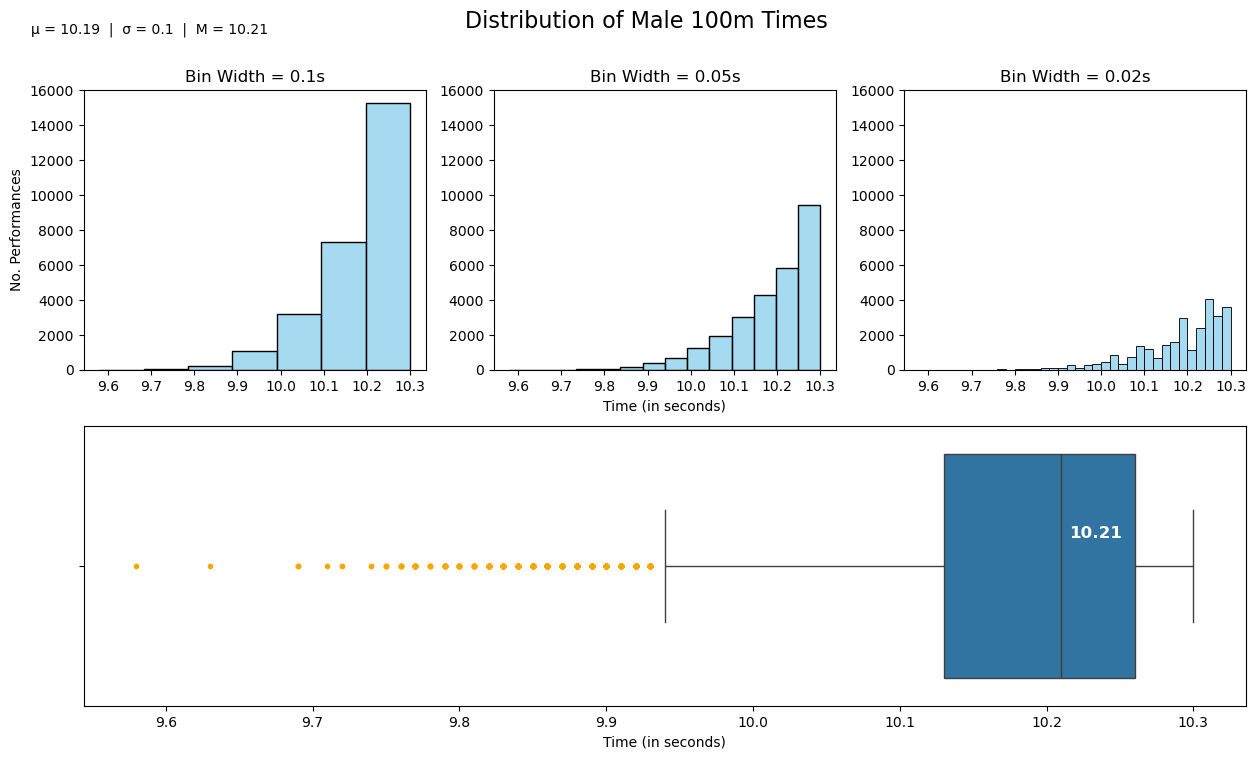

In [4]:
fig, axes = plt.subplot_mosaic("ABC;DDD", figsize=(15, 8), sharey=False, sharex=False)
axes["A"].sharey(axes["B"])
axes["B"].sharey(axes["C"])

fig.suptitle("Distribution of Male 100m Times", fontsize=16)

mean = round(df["Mark"].mean(), 2)
stdev = round(df["Mark"].std(), 2)
median = round(df["Mark"].median(), 2)

sns.histplot(data=df, ax=axes["A"], x="Mark", binwidth=0.1, color="skyblue", edgecolor="black").set(title="Bin Width = 0.1s", xlabel="", ylabel="No. Performances")
sns.histplot(data=df, ax=axes["B"], x="Mark", binwidth=0.05, color="skyblue", edgecolor="black").set(title="Bin Width = 0.05s", xlabel="Time (in seconds)", ylabel="")
sns.histplot(data=df, ax=axes["C"], x="Mark", binwidth=0.02, color="skyblue", edgecolor="black").set(title="Bin Width = 0.02s", xlabel="", ylabel="")

sns.boxplot(data=df, ax=axes["D"], x="Mark", flierprops={"markerfacecolor": "orange", "markeredgecolor": "orange", "markersize": 3}).set(xlabel="Time (in seconds)")
axes["D"].annotate(text=str(median), xy=(median * 1.0005, -0.1), fontsize=12, color="white", fontweight="semibold")
fig.text(0.09, 0.95, f"μ = {mean}  |  σ = {stdev}  |  M = {median}")

plt.show()

### 2. What is the most common age for a male athlete to run his personal best?
<font size="3">
The histogram below shows that the most common age for a male athlete to run his personal best is 22. Majority of the data can be seen in the early to mid twenties (20-25) range, and this is supported by the boxplot beneath. Whilst uncommon, there are some outlier cases where athletes run their personal best in their thirties, and in one case, Kim Collins of Saint Kitts and Nevis, at 40 years of age.
</font>

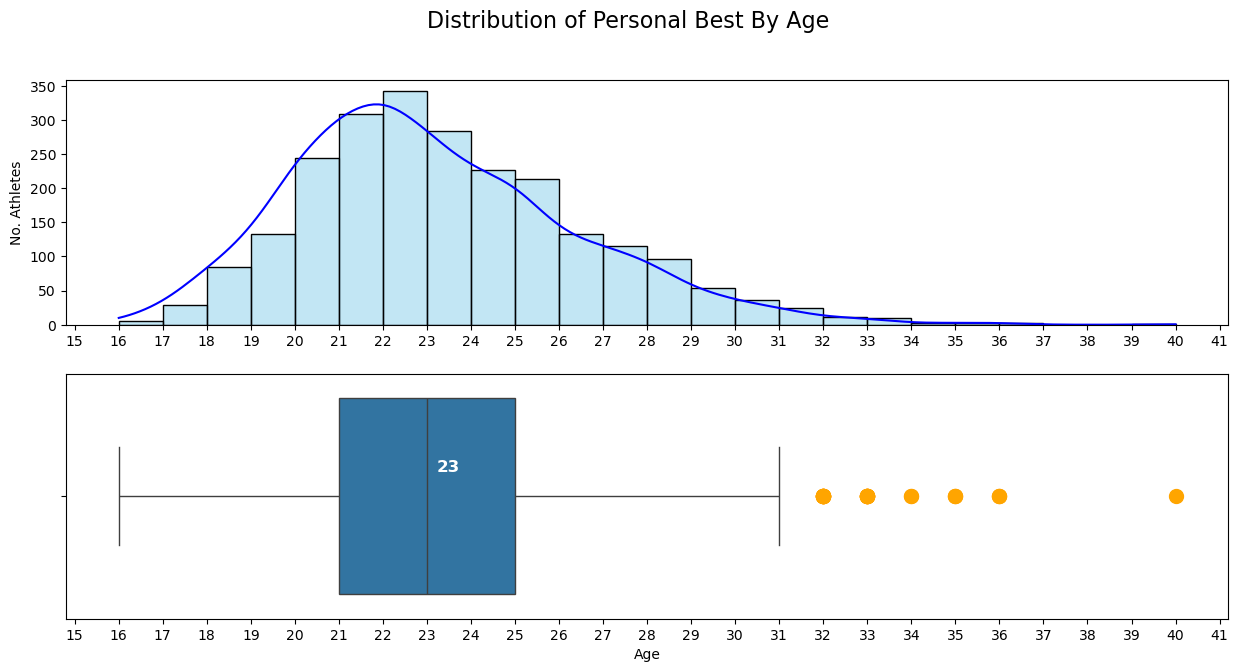

In [5]:
df_pb = df.filter(pl.col("Is Personal Best")==True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7), sharey=False, sharex=False)
fig.suptitle("Distribution of Personal Best By Age", fontsize=16)

sns.histplot(data=df_pb, ax=ax1, x="Age", color="skyblue", edgecolor="black", binwidth=1, kde=True, linewidth=1) \
.set(title="", xlabel="", ylabel="No. Athletes")
ax1.lines[0].set_color('blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

median = df_pb["Age"].median()
sns.boxplot(data=df_pb, ax=ax2, x="Age", flierprops={"markerfacecolor": "orange", "markeredgecolor": "orange", "markersize": 10})
ax2.annotate(text=str(int(median)), xy=(median * 1.01, -0.1), fontsize=12, color="white", fontweight="semibold")
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### 3. What are the fastest times for each nation?
<font size="3">
The bar chart below shows a sharp decrease in times for the United States of America and Jamaica compared with the rest of the world, being the only two nations to produce athletes that have achieved times under 9.70 seconds.
</font>

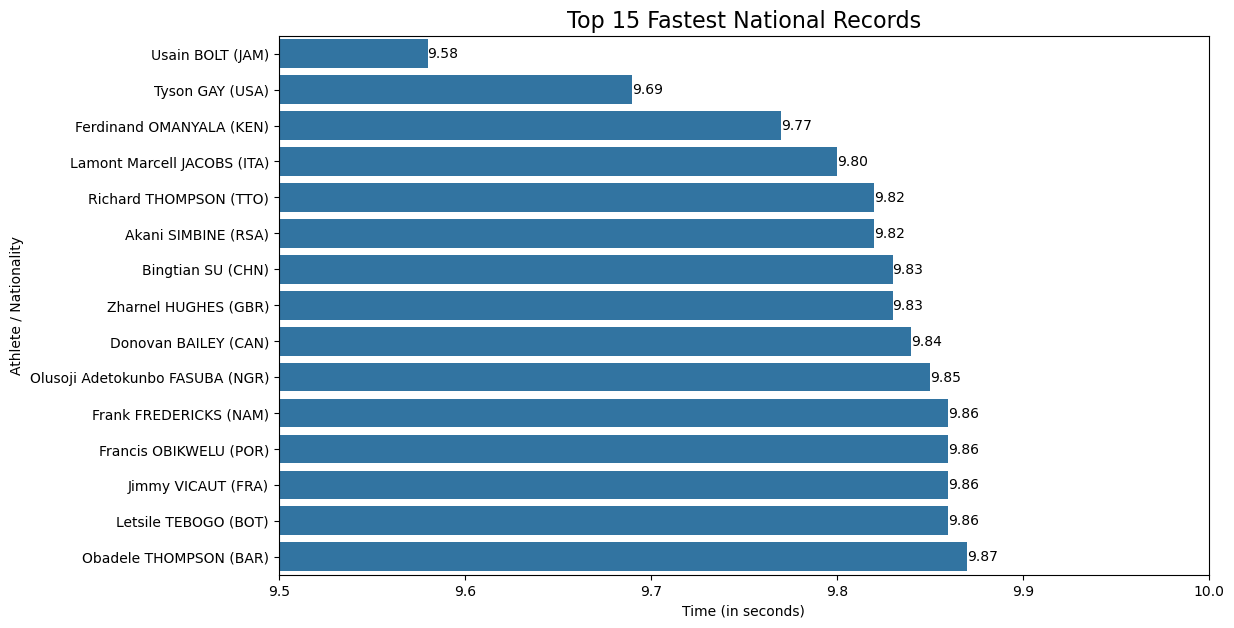

In [6]:
num_limit = 15
df_nr = df.filter(pl.col("Is National Record") == True).sort("Mark").limit(num_limit)

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data=df_nr, x="Mark", y="Competitor Nat", ax=ax)
ax.set_xlim(9.5, 10)
ax.set_title(f"Top {num_limit} Fastest National Records", fontsize=16)
ax.set_xlabel("Time (in seconds)")
ax.set_ylabel("Athlete / Nationality")
[ax.bar_label(bar, fmt='%.2f') for bar in ax.containers]

plt.show()

### 4. How has the male 100m world record progressed over time?
<font size="3">
The line chart below shows the progression of the world record from 1958 until the current world record set in 2009. In 51 years, the world record has decreased by a total of 0.71 seconds across 16 separate occasions.
<br><i><font size="2">Note: some years of data are missing prior to 1971</font></i>
</font>

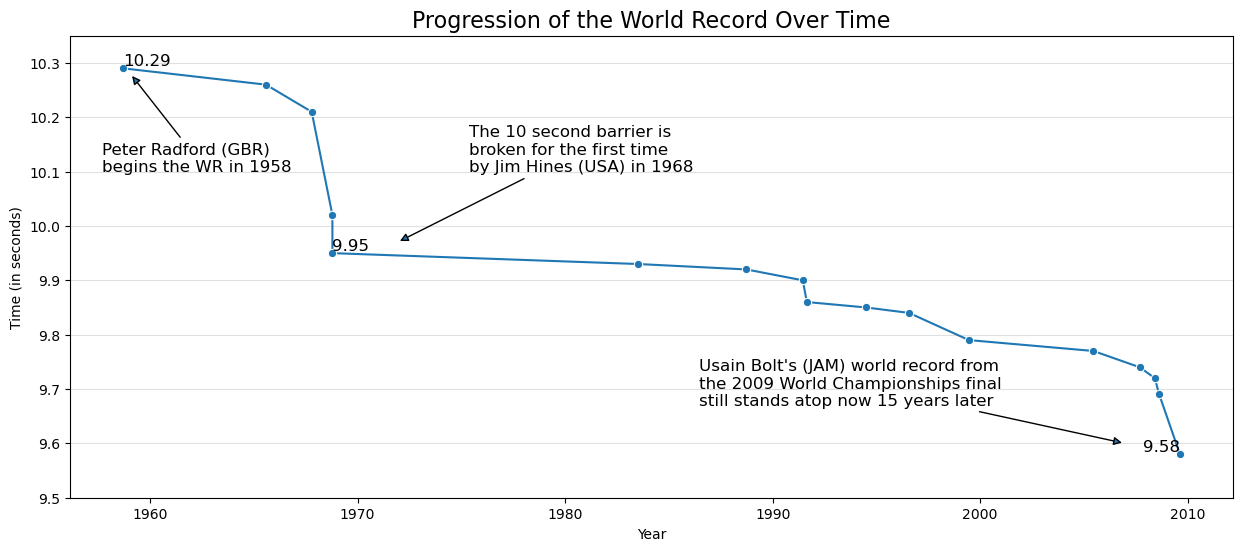

In [7]:
df_wr = df.sort("Date") \
.with_columns(pl.col("Mark").cum_min().alias("World Record")) \
.with_columns((pl.col("World Record").shift(1) != pl.col("World Record")).fill_null(True).alias("Is New World Record")) \
.filter(pl.col("Is New World Record") == True)

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=df_wr, x="Date", y="Mark", marker="o")
ax.set_ylim(9.5, 10.35)
ax.set_title("Progression of the World Record Over Time", fontsize=16)
ax.set_xlabel("Year")
ax.set_ylabel("Time (in seconds)")

for line in ax.lines:
    for i, (x, y) in enumerate(zip(line.get_xdata(), line.get_ydata())):
        if i in [0, 4]:
            ax.text(x, y, f'{y:.2f}', fontsize=12, ha='left', va='bottom')
        elif i == 16:
            ax.text(x, y, f'{y:.2f}', fontsize=12, ha='right', va='bottom')

ax.annotate(
    "Peter Radford (GBR)\nbegins the WR in 1958",
    xy=(-4000, 10.28), xytext=(-4500, 10.1), fontsize=12, arrowprops=dict(arrowstyle="-|>")
)
ax.annotate(
    "The 10 second barrier is\nbroken for the first time\nby Jim Hines (USA) in 1968",
    xy=(700, 9.97), xytext=(1965, 10.1), fontsize=12, arrowprops=dict(arrowstyle="-|>")
)
ax.annotate(
    "Usain Bolt's (JAM) world record from\nthe 2009 World Championships final\nstill stands atop now 15 years later",
    xy=(13500, 9.6), xytext=(6000, 9.67), fontsize=12, arrowprops=dict(arrowstyle="-|>")
)

plt.grid(axis="y", color="#E0E0E0")

plt.show()

### 5. How has the world lead (fastest time in the year) progressed over time?
<font size="3">
The line chart below shows a fairly steady decrease in the world lead over the past 60+ years, with a clear golden period around 2007-2012. The United States has dominated the world lead throughout the decades, with Jamaica coming to prominence from 2005 when Asafa Powell ran his first world record.
<br><i><font size="2">Note: some years of data are missing prior to 1971</font></i>
</font>

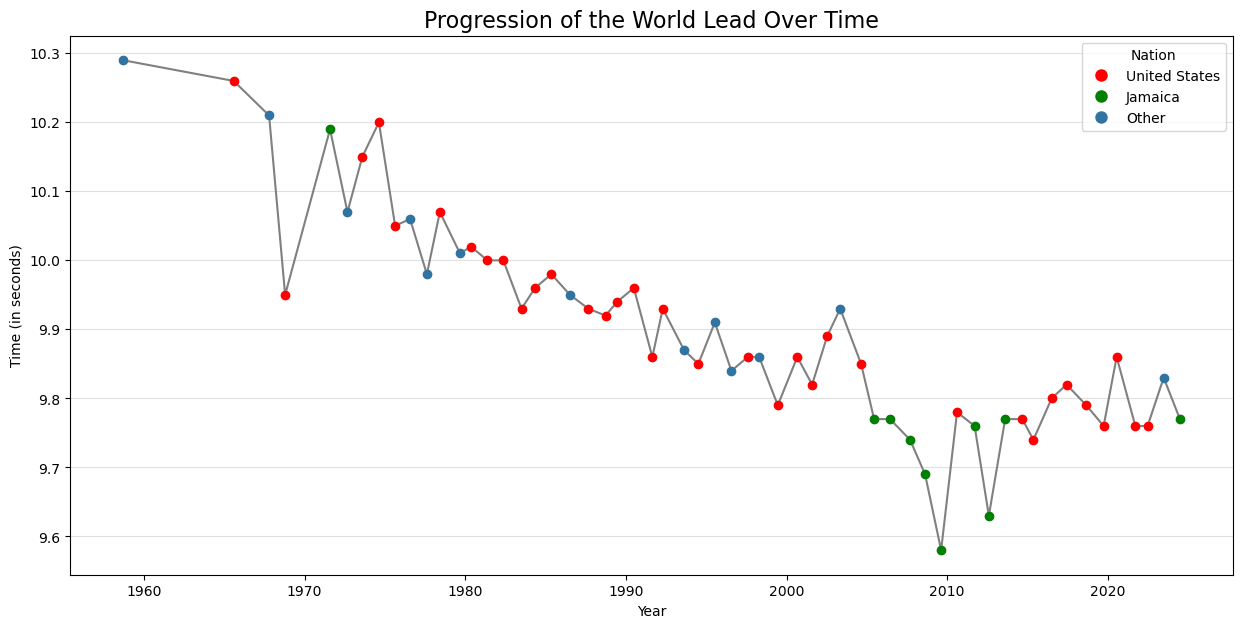

In [8]:
df_wl = df \
.with_columns(
    (pl.col("Mark").rank("ordinal").over(pl.col("Date").dt.year()) == 1).alias("Is World Lead"),
    pl.when(pl.col("Nation").is_in(["Jamaica", "United States"])).then(pl.col("Nation")).otherwise(pl.lit("Other")).alias("Nation Group")
) \
.filter(pl.col("Is World Lead") == 1) \
.with_columns(
    pl.when(pl.col("Nation Group") == "Jamaica").then(pl.lit("green"))
        .when(pl.col("Nation Group") == "United States").then(pl.lit("red"))
        .otherwise(pl.lit("#3274a1")
    ).alias("marker_colour")    
) \
.sort(pl.col("Date"))

fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(data=df_wl, x="Date", y="Mark", marker="o", color="grey")
ax.set_title("Progression of the World Lead Over Time", fontsize=16)
ax.set_xlabel("Year")
ax.set_ylabel("Time (in seconds)")

colours = df_wl["marker_colour"]

line = ax.get_lines()[0]  # Get the first line in the plot
xdata, ydata = line.get_xdata(), line.get_ydata()
for xi, yi, colour in zip(xdata, ydata, colours):
    plt.scatter(xi, yi, color=colour, zorder=5)

# Create a custom legend
legend = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='United States'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Jamaica'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#3274a1', markersize=10, label='Other')
]
plt.legend(handles=legend, loc='upper right', title="Nation")
plt.grid(axis="y", color="#E0E0E0")

plt.show()

### 6. Which athletes have achieved the most sub 10.00, 9.90 and 9.80 second performances?
<font size="3">
Jamaican athlete, Asafa Powell, often referred to as "the sub 10 king", has achieved the most sub 10 second performances, just shy of 100 with a total of 97. With each 0.1 second decrease, Usain Bolt gradually makes his way to the top, with a total of 12 sub 9.80 second performances.
</font>

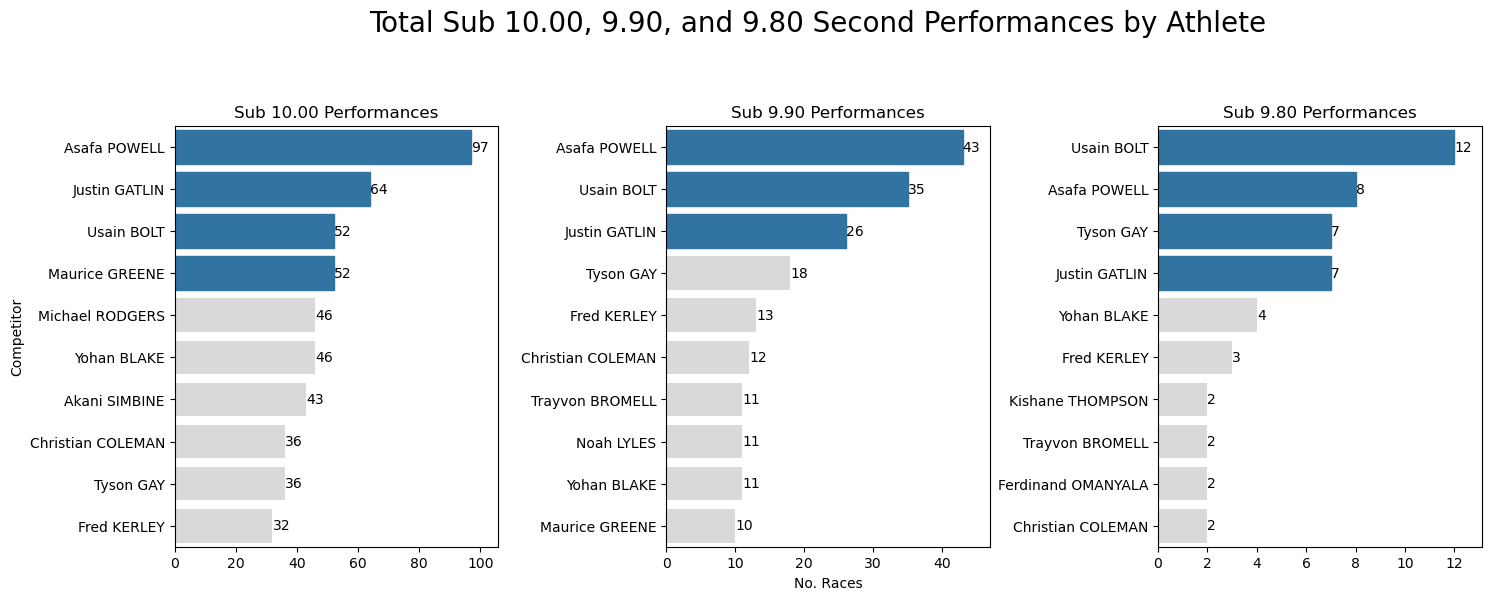

In [9]:
def filter_df_sub_n(df, sub_n, num_limit):
    return df.filter(pl.col("Mark") < sub_n).group_by("Competitor").len().sort("len", descending=True).limit(num_limit).rename({"len": "No. Races"})

num_limit = 10
df_sub_10 = filter_df_sub_n(df, 10, num_limit)
df_sub_9_9 = filter_df_sub_n(df, 9.9, num_limit)
df_sub_9_8 = filter_df_sub_n(df, 9.8, num_limit)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 7))
fig.tight_layout(pad=9)
fig.suptitle("Total Sub 10.00, 9.90, and 9.80 Second Performances by Athlete", fontsize=20)
sns.barplot(data=df_sub_10, x="No. Races", y="Competitor", ax=ax1, color="#D9D9D9").set(title="Sub 10.00 Performances", xlabel="", ylabel="Competitor")
sns.barplot(data=df_sub_9_9, x="No. Races", y="Competitor", ax=ax2, color="#D9D9D9").set(title="Sub 9.90 Performances", xlabel="No. Races", ylabel="")
sns.barplot(data=df_sub_9_8, x="No. Races", y="Competitor", ax=ax3, color="#D9D9D9").set(title="Sub 9.80 Performances", xlabel="", ylabel="")

# Apply bar colours
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_xlim(0, ax.get_xlim()[1] * 1.04)
    for bar in ax.patches:
        if i == 0 and bar.get_width() in df_sub_10.select("No. Races").limit(3).to_numpy():
            bar.set_color("#3274A1")
        elif i == 1 and bar.get_width() in df_sub_9_9.select("No. Races").limit(3).to_numpy():
            bar.set_color("#3274A1")
        elif i == 2 and bar.get_width() in df_sub_9_8.select("No. Races").limit(3).to_numpy():
            bar.set_color("#3274A1")
    for bar in ax.containers:
        ax.bar_label(bar, fmt='%.0f')

plt.show()

### 7. Who are the youngest and oldest athletes to achieve sub 10 second performances?
<font size="3">
The heat maps below show the athletes who defy the conventional standards for older and younger 100m athletes.
</font>

In [10]:
def get_heatmap_data(df, age_operator, age, time):
    # Mapping between string and operator
    operator_map = {
        ">": operator.gt, "<": operator.lt,
        ">=": operator.ge, "<=": operator.le,
        "==": operator.eq, "!=": operator.ne
    }
    operator_function = operator_map.get(age_operator)
    # Filter only times achieved for the specified age and time ranges
    df_age = df.filter((operator_function(pl.col("Age"), age)) & (pl.col("Mark") < time)) \
        .select("Competitor Nat", pl.col("Age").cast(str), "Mark") \
        .pivot("Age", index="Competitor Nat", aggregate_function="len", sort_columns=True) \
        .fill_null(strategy="zero")
    # Extract and return the values, rows, and columns from the dataframe
    arr_age = df_age.select(pl.all().exclude("Competitor Nat")).to_numpy()
    row_labels = df_age["Competitor Nat"].to_list()
    column_labels = df_age.columns[1:]
    return arr_age, row_labels, column_labels
    
# Return only integer values in the colour bar
def format_colour_bar(ax):
    colour_bar = ax.collections[0].colorbar
    min_tick, max_tick = int(colour_bar.vmin), int(colour_bar.vmax)
    ticks = list(range(min_tick, max_tick + 1))
    colour_bar.set_ticks(ticks)
    colour_bar.set_ticklabels(ticks)

<font size="3">
10 athletes have achieved sub 10 second times at 33 years or older, most notably Justin Gatlin who achieved this feat on 25 separate occasions. Kim Collins is the oldest athlete to achieve a sub 10 second performance, when he ran is personal best of 9.93 seconds at age 40.
</font>

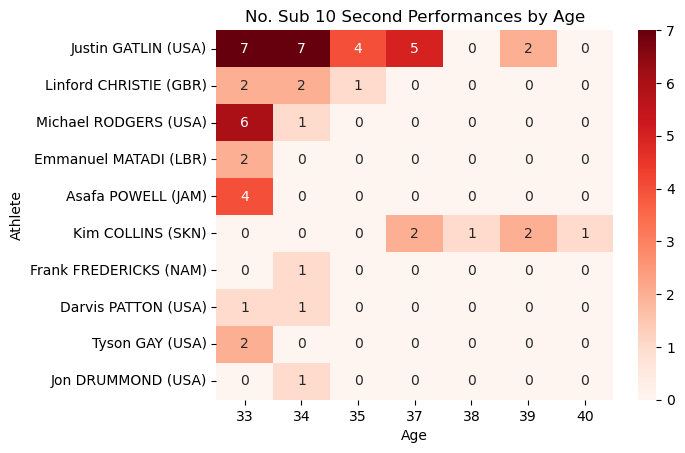

In [11]:
arr_age, row_labels, column_labels = get_heatmap_data(df=df, age_operator=">=", age=33, time=10)

fig, ax = plt.subplots()

sns.heatmap(arr_age, annot=True, cmap='Reds', xticklabels=column_labels, yticklabels=row_labels)
ax.set_title("No. Sub 10 Second Performances by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Athlete")
format_colour_bar(ax)

plt.show()

<font size="3">
On the other end of the spectrum, only 8 teenage athletes have achieved sub 10 second times, with Christian Miller most notably being the only athlete to achieve this feat at age 17.
</font>

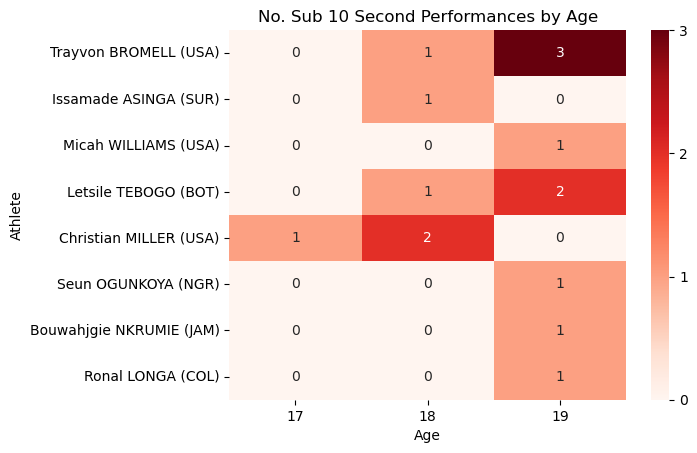

In [12]:
arr_age, row_labels, column_labels = get_heatmap_data(df=df, age_operator="<=", age=19, time=10)

fig, ax = plt.subplots()

sns.heatmap(arr_age, annot=True, cmap='Reds', xticklabels=column_labels, yticklabels=row_labels)
ax.set_title("No. Sub 10 Second Performances by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Athlete")
format_colour_bar(ax)

plt.show()

### 8. What is the fastest time that didn't place first?
<font size="3">
Tyson Gay's second place finish of 9.71 seconds in the final of the 2009 World Championships is the fastest time achieved by an athlete that didn't place first. It is the 6th fastest time ever recorded in the 100m sprint, and yet still fell significantly short of Usain Bolt's world record time of 9.58 seconds in that same final.
</font>

In [13]:
df.filter(pl.col("Pos Adjusted") != "1").sort(pl.col("Mark")).limit(1)

Rank,Mark,WIND,Competitor,DOB,Nat,Pos,Venue,Date,Results Score,Competitor Nat,Age,Current Age,Pos Adjusted,Is Personal Best,Personal Best,Is National Record,Year,Nation,Longitude,Latitude
i64,f64,f64,str,date,str,str,str,date,i64,str,i64,i64,str,bool,f64,bool,i32,str,f64,f64
6,9.71,0.9,"""Tyson GAY""",1982-08-09,"""USA""","""2""","""Olympiastadion, Berlin (GER)""",2009-08-16,1308,"""Tyson GAY (USA)""",27,42,"""2""",false,9.69,false,2009,"""United States""",-95.7129,37.0902


### 9. How has Australian sprinting progressed over time?
<font size="3">
The boxplots below show the progression of Australian sprinting over several decades. A number of years stand out from the rest (98, 03, 07, 19, 21, 23), where low 10 second times were achieved, although most notably, 2003 is the only year where a sub 10 second time was achieved by Australia's fastest man to date, Patrick Johnson, where he set the national record of 9.93 seconds. The general longitudinal trend shows peaks and troughs throughout the years, with Australian sprinting currently finding itself in what appears to be an upswing, although there's no saying whether this trend will continue given the number of young athletes still competing professionally.
<br><i><font size="2">Note: some years of data are missing prior to 1993</font></i>
</font>

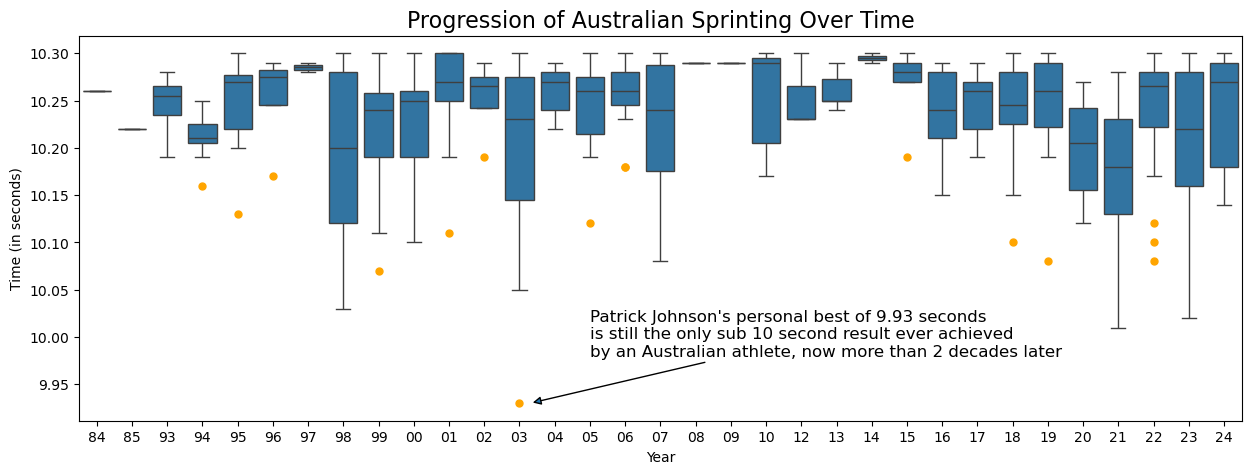

In [14]:
df_aus = df.filter(pl.col("Nation") == "Australia")

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df_aus, x="Year", y="Mark", flierprops={"markerfacecolor": "orange", "markeredgecolor": "orange", "markersize": 5})

ax.set_title("Progression of Australian Sprinting Over Time", fontsize=16)
ax.set_xlabel("Year")
ax.set_ylabel("Time (in seconds)")

years = list(df_aus["Year"].unique())
year_labels = [str(year)[-2:] for year in years]
year_pos = list(range(len(years)))

plt.xticks(year_pos, year_labels)

ax.annotate(
    "Patrick Johnson's personal best of 9.93 seconds\nis still the only sub 10 second result ever achieved\nby an Australian athlete, now more than 2 decades later",
    xy=(12.3, 9.93), xytext=(14, 9.98), fontsize=12, arrowprops=dict(arrowstyle="-|>")
)

plt.show()